Questions
---------
1. The plan is to estimate Tgal from the 408Mhz all-sky map obtained by Haslam C. G. T., Klein U., Salter C. J.,  Stoffel H., WilsonW. E., Cleary M. N., Cooke D. J., Thomasson P., 1981,A&A, 100, 209.

   A more recently reduced version of this map was produced by Remazeilles et al., 2015, MNRAS, 451, 4311. This has improvements to the reduction, particularly destriping. Unfortunately, the archived Healpix map with this result haslam408_ds_Remazeilles2014.fits seems to have bad format. The FITS table column should contain a 1d array with all the Healpix pixels but is instead 2d - doh, me doing something wrong?
   
   Actually, yes. I think the Remazeilles map was written out by IDL which formats the table in a particular way. The healpy FITS writer has a format flag to specify the format used, and the healpy FITS reader can handle either format transparently. The next cell uses healpy to read in the Remazeilles map, then write it out again in the 'non-IDL' format that astropy_healpix can read. 

   Another fallback option would be to use the Healpix file for the original reduction lambda_haslam408_nofilt.fits from https://lambda.gsfc.nasa.gov/product/foreground/fg_haslam_get.cfm, which is already in standard format.

In [27]:
# This cell uses healpy (that is, not the astropy_healpix module) to read in the Remazeilles et al. IDL-format 
# healpix file and export it in NSIDE=512 and NSIDE=256 versions in non-IDL format.

# These files can be read by astropy_healpix. The NSIDE=256 version gives a smaller map file with bigger pixels.

# Paths are hard-coded, so code in this cell is commented out to allow the whole notebook run on another machine.

# healpy installed on MacOS with:
# conda config --add channels conda-forge
# conda install healpy

# UNCOMMENT code from here if you want the cell to do anything
## stop healpy warnings being reported - and halting execution

#import warnings;
#warnings.filterwarnings('ignore')

#import healpy
#import matplotlib.pyplot as plt

# read the map in - IDL fomrat is handled transparently
#map_in = healpy.fitsfunc.read_map('/Users/jfl/Downloads/haslam408_ds_Remazeilles2014.fits',
#                                  field=0, dtype=None, nest=True, verbose=False, h=False)
## map array should be 1d
#print(map_in.shape)

## write out in non-IDL format
#healpy.fitsfunc.write_map('/Users/jfl/haslam408_ds_Remazeilles2014_nonIDL.fits', map_in, nest=True,
#                          dtype=None, fits_IDL=False, coord='GALACTIC', partial=False, column_names=None, 
#                          column_units=['K'], extra_header=(), overwrite=True)

## convert from NSIDE=512 to NSIDE=256
#map_out = healpy.pixelfunc.ud_grade(map_in, nside_out=256, pess=False, order_in='NESTED',
#                                    order_out='NESTED', power=None, dtype=None)
#print(map_out.shape)

## write out the NSIDE=256 version in non-IDL format
#healpy.fitsfunc.write_map('/Users/jfl/haslam408_ds_Remazeilles2014_nonIDL_nside256.fits', map_out,
#                          nest=True, dtype=None, fits_IDL=False, coord='GALACTIC', partial=False,
#                          column_names=None, column_units=['K'], extra_header=(), overwrite=True)

## plot the map in mollweide projection for doc purposes

#healpy.visufunc.mollview(map=map_in, fig=None, rot=None, coord='G', unit='K', xsize=800,
#                         title='Remazeilles et al. 408MHz', nest=True, min=None, max=None, flip='astro',
#                         remove_dip=False, remove_mono=False, gal_cut=0, format='%g', 
#                         format2='%g', cbar=True, cmap=None, badcolor='gray', bgcolor='white',
#                         notext=False, norm='log', hold=False, reuse_axes=False, margins=None, 
#                         sub=None, nlocs=2, return_projected_map=False)
#plt.show()

## can't figure out how to use plt.savefig with the healpy plot - just grab the image if need be

Theory
------

The equations relating $T_{sys}$ to sensitivity are as follows:

* The SEFD of each dish
  \begin{equation}
  SEFD_{dish} = \frac{2kT_{sys}}{\eta_A A}
  \end{equation}

* The SEFD of the array
  \begin{equation}
  SEFD_{\mathrm{array}} = \frac{1}{\sqrt{
      \frac{n_{\mathrm{SKA}}(n_{\mathrm{SKA}} - 1)}{SEFD_{\mathrm{SKA}}^2} +
      \frac{2 n_{\mathrm{SKA}} n_{\mathrm{MeerKAT}}}{SEFD_{\mathrm{SKA}} SEFD_{\mathrm{MeerKAT}}} +
      \frac{n_{\mathrm{MeerKAT}}(n_{\mathrm{MeerKAT}} - 1)}{SEFD_{\mathrm{MeerKAT}}^2}
  }}
  \end{equation}

* The sensitivity
  \begin{equation}
  \Delta S_{min} \exp (-\tau_{atm}) = \frac{SEFD_{array}}{\eta_s \sqrt{2Bt}} Jy
  \end{equation}
  
The dish SEFD is proportional to $T_{sys}$. If we assume that $T_{sys}$ is roughly the same for all dishes then the array SEFD is also proportional to $T_{sys}$ and so is $\Delta S_{min}$.

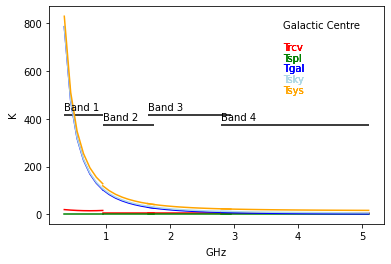

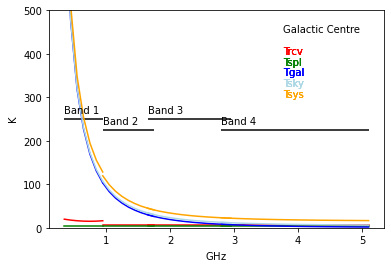

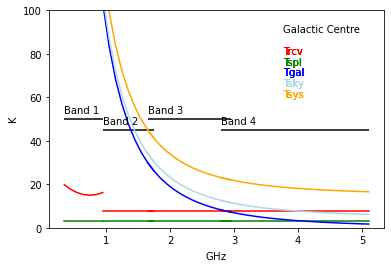

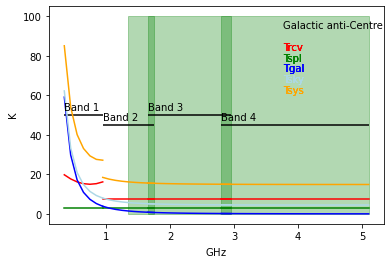

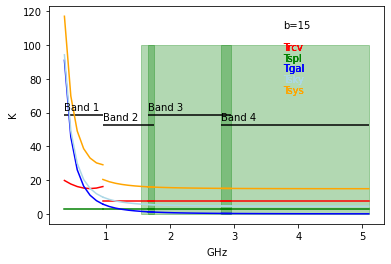

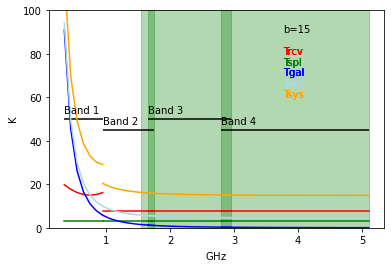

green areas show where Tgal is less than 10% of Tsys


In [9]:
# The sensitivity is proportional to Tsys. The method in this cell demonstrates the relative importance of Tgal in the 
# calculation of Tsys at various frequencies/bands. The method is to be called from another cell.

# add src to path to be able to pick up ska_ost_senscalc module
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.visualization import quantity_support
import astropy.units as u
from ska_ost_senscalc.mid import MidCalculator


def plot_band(obs_freq, sc):
    trcv = sc.Trcv_ska
    tspl = np.array(trcv)
    tspl[:] = sc.Tspl_ska
    tsky = sc.Tsky
    tgal = sc.Tgal
    tsys = sc.Tsys_ska
    
    plt.plot(obs_freq, trcv, color='red')
    plt.text(0.7, 0.8, 'Trcv', color='red', transform=plt.gca().transAxes)
    plt.plot(obs_freq, tspl, color='green')
    plt.text(0.7, 0.75, 'Tspl', color='green', transform=plt.gca().transAxes)
    plt.plot(obs_freq, tgal, color='blue')
    plt.text(0.7, 0.7, 'Tgal', color='blue', transform=plt.gca().transAxes)
    plt.plot(obs_freq, tsky, color='lightblue')
    plt.text(0.7, 0.65, 'Tsky', color='lightblue', transform=plt.gca().transAxes)
    plt.plot(obs_freq, tsys, color='orange')
    plt.text(0.7, 0.6, 'Tsys', color='orange', transform=plt.gca().transAxes)
    
    tenper = obs_freq[tgal < 0.1 * tsys]
    if len(tenper) > 0:
        plt.fill_betweenx([0, 100], [tenper[0], tenper[0]], [tenper[-1], tenper[-1]], alpha=0.3, color='green')
    

def go(target, Tmin=None, Tmax=None, title=''):
    
    # turn on quantity plotting support 
    quantity_support()

    plt.figure()

    # band 1
    obs_freq1 = np.arange(0.35, 1.050, 0.1) * u.GHz
    sc = MidCalculator("Band 1", obs_freq1, 0.1 * u.GHz, "Good", "full", gc)
    plot_band(obs_freq1, sc)
    
    # band 2
    obs_freq2 = np.arange(0.95, 1.76, 0.1) * u.GHz
    sc = MidCalculator("Band 2", obs_freq2, 0.1 * u.GHz, "Good", "full", gc)
    plot_band(obs_freq2, sc)

    # band 3
    obs_freq3 = np.arange(1.65, 3.05, 0.1) * u.GHz
    sc = MidCalculator("Band 3", obs_freq3, 0.1 * u.GHz, "Good", "full", gc)
    plot_band(obs_freq3, sc)

    # band 4
    obs_freq4 = np.arange(2.8, 5.18, 0.1) * u.GHz
    sc = MidCalculator("Band 4", obs_freq4, 0.1 * u.GHz, "Good", "full", gc)
    plot_band(obs_freq4, sc)
    
    plt.ylim(Tmin, Tmax)
    plt.text(0.7, 0.9, title, transform=plt.gca().transAxes)
    
    ymin, ymax = plt.ylim()
    ymid = (ymax + ymin) / 2.0
    
    plt.hlines(ymid, obs_freq1[0], obs_freq1[-1], color='black')
    plt.text(obs_freq1[0], ymid * 1.05, 'Band 1')
    plt.hlines(ymid * 0.9, obs_freq2[0], obs_freq2[-1], color='black')
    plt.text(obs_freq2[0], ymid * 0.95, 'Band 2')
    plt.hlines(ymid, obs_freq3[0], obs_freq3[-1], color='black')
    plt.text(obs_freq3[0], ymid * 1.05, 'Band 3')
    plt.hlines(ymid * 0.9, obs_freq4[0], obs_freq4[-1], color='black')
    plt.text(obs_freq4[0], ymid * 0.95, 'Band 4')
    
    plt.show()
    
# run the code for various targets
    
# Galactic Centre
gc = SkyCoord(359.94423568 * u.deg, -00.04616002 * u.deg, frame="galactic")
go(gc, title='Galactic Centre')
go(gc, 0, 500, title='Galactic Centre')
go(gc, 0, 100, title='Galactic Centre')

# Galactic antiCentre
gc = SkyCoord(180.0 * u.deg, -00.04616002 * u.deg, frame="galactic")
go(gc, title='Galactic anti-Centre')

# Galactic b=+15
gc = SkyCoord(359.94423568 * u.deg, 15.0 * u.deg, frame="galactic")
go(gc, title='b=15')
go(gc, 0, 100, title='b=15')

print('green areas show where Tgal is less than 10% of Tsys')

Relative Importance of Tgal
---------------------------
The green areas in some of the plots above show frequencies where Tgal contributes less than 10% of Tsys.

The results show that where Tgal is very bright at the Galactic Centre then Tgal contributes more than
10% of Tsys for all bands 1-4, though much more strongly at low frequency.
      
Towards the Galactic anti-centre, that is in the Galactic plane but in the direction opposite to the 
Centre, Tgal contributes more than 10% for bands 1 and 2.
      
For l=0, b=+15 (15 degrees out of the plane), Tgal contributes more than 10% for bands 1 and 2.

The raw resolution of the 408MHz map is 0.85deg or 51 arcsec
The pixsize of the NSIDE=512 healpix map is 6.870972823634812 arcmin
The pixsize of the NSIDE=256 healpix map is 13.741945647269624 arcmin

Galactic Centre
---------------

Band 1
  Observing freq 0.35 GHz
    FWHM 226.12916832000002 arcmin
    npixels 3538
    target pix data 1874.103
    data max 1933.7155
    data min 156.68787
    data med 312.7144
    convolved 408MHz 531.3153835590952
    convolved 0.35 GHz 809.9919767594877
    time 1.6531412601470947
    Tsys convolved [833.15174095] K
    Tsys target pixel [2872.06013175] K
    256 npixels 916
    256 target pix data 1778.0925
    256 data max 1860.3927
    256 data min 155.99542
    256 data med 309.9134
    256 convolved 408MHz 529.4854539077677
    256 convolved 0.35 GHz 807.2022432387291
    256 time 0.47142887115478516
    256 Tsys convolved [833.15174095] K
    256 Tsys target pixel [2872.06013175] K

  Observing freq 0.9999999999999999 GHz
    FWHM 79.14520891

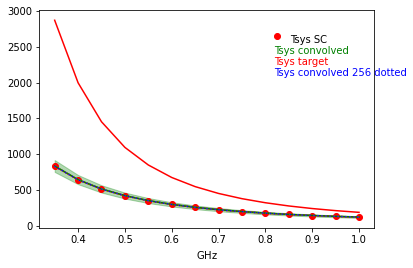

Band 2
  Observing freq 0.95 GHz
    FWHM 83.3107462231579 arcmin
    npixels 513
    target pix data 1874.103
    data max 1933.7155
    data min 336.07196
    data med 744.4503
    convolved 408MHz 1090.297280840136
    convolved 0.95 GHz 106.68920105775591
    time 0.25559210777282715
    Tsys convolved [120.71627646] K
    Tsys target pixel [196.9552515] K
    256 npixels 142
    256 target pix data 1778.0925
    256 data max 1860.3927
    256 data min 332.88672
    256 data med 708.7402
    256 convolved 408MHz 1079.2606082688094
    256 convolved 0.95 GHz 105.60922608243216
    256 time 0.09903597831726074
    256 Tsys convolved [120.71627646] K
    256 Tsys target pixel [196.9552515] K

  Observing freq 1.7500000000000007 GHz
    FWHM 45.22583366399999 arcmin
    npixels 162
    target pix data 1874.103
    data max 1933.7155
    data min 699.05396
    data med 1186.8506
    convolved 408MHz 1471.4890570509879
    convolved 1.7500000000000007 GHz 26.836004211608596
    time 0.08

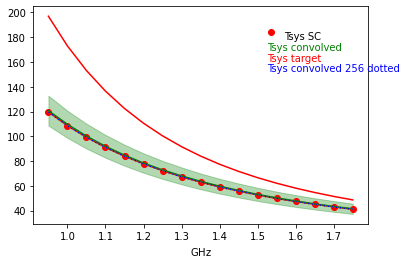

Band 3
  Observing freq 1.65 GHz
    FWHM 47.96679328000001 arcmin
    npixels 183
    target pix data 1874.103
    data max 1933.7155
    data min 644.79065
    data med 1126.2473
    convolved 408MHz 1438.1927195110895
    convolved 1.65 GHz 30.83554919599031
    time 0.10799694061279297
    Tsys convolved [45.44045762] K
    Tsys target pixel [54.73065036] K
    256 npixels 52
    256 target pix data 1778.0925
    256 data max 1860.3927
    256 data min 662.8194
    256 data med 1099.344
    256 convolved 408MHz 1421.058541476649
    256 convolved 1.65 GHz 30.468184111640934
    256 time 0.026061058044433594
    256 Tsys convolved [45.44045762] K
    256 Tsys target pixel [54.73065036] K

  Observing freq 2.950000000000001 GHz
    FWHM 26.828884376949144 arcmin
    npixels 63
    target pix data 1874.103
    data max 1933.7155
    data min 1103.0065
    data med 1513.3262
    convolved 408MHz 1695.6178179933506
    convolved 2.950000000000001 GHz 7.355850196550092
    time 0.0411159

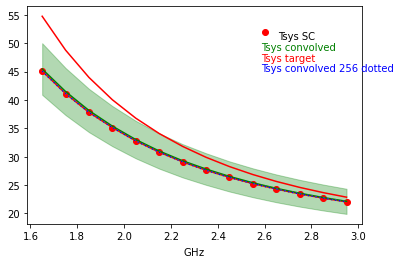

Band 4
  Observing freq 2.8 GHz
    FWHM 28.266146040000002 arcmin
    npixels 71
    target pix data 1874.103
    data max 1933.7155
    data min 1074.7335
    data med 1490.0974
    convolved 408MHz 1676.4389139549437
    convolved 2.8 GHz 8.394959311418589
    time 0.10551810264587402
    Tsys convolved [23.17662525] K
    Tsys target pixel [24.16052444] K
    256 npixels 23
    256 target pix data 1778.0925
    256 data max 1860.3927
    256 data min 1035.8982
    256 data med 1363.491
    256 convolved 408MHz 1653.264141770622
    256 convolved 2.8 GHz 8.278908993140183
    256 time 0.025002002716064453
    256 Tsys convolved [23.17662525] K
    256 Tsys target pixel [24.16052444] K

  Observing freq 5.000000000000002 GHz
    FWHM 15.829041782399996 arcmin
    npixels 27
    target pix data 1874.103
    data max 1933.7155
    data min 1475.3948
    data med 1701.8204
    convolved 408MHz 1820.943036495916
    convolved 5.000000000000002 GHz 1.851161446489883
    time 0.01531004905

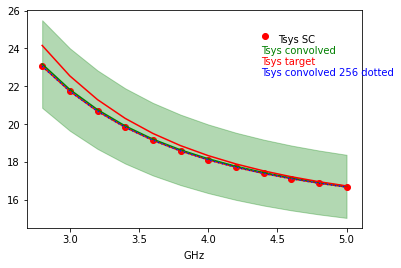


Galactic anti-Centre
--------------------

Band 1
  Observing freq 0.35 GHz
    FWHM 226.12916832000002 arcmin
    npixels 3540
    target pix data 38.691765
    data max 46.730686
    data min 30.810055
    data med 38.97989
    convolved 408MHz 38.705262723490534
    convolved 0.35 GHz 59.0062950076589
    time 2.2910048961639404
    Tsys convolved [84.92487124] K
    Tsys target pixel [84.90445599] K
    256 npixels 920
    256 target pix data 38.242535
    256 data max 46.596764
    256 data min 30.823193
    256 data med 38.972996
    256 convolved 408MHz 38.700492762060065
    256 convolved 0.35 GHz 58.99902318642487
    256 time 0.5557470321655273
    256 Tsys convolved [84.92487124] K
    256 Tsys target pixel [84.90445599] K

  Observing freq 0.9999999999999999 GHz
    FWHM 79.14520891200003 arcmin
    npixels 462
    target pix data 38.691765
    data max 45.70718
    data min 33.26235
    data med 39.15413
    convolved 408MHz 39.37924806551619
    convolved 0.9999999999999

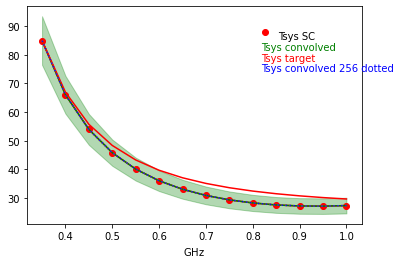

Band 2
  Observing freq 0.95 GHz
    FWHM 83.3107462231579 arcmin
    npixels 520
    target pix data 38.691765
    data max 45.70718
    data min 32.99343
    data med 39.066624
    convolved 408MHz 39.35826937966105
    convolved 0.95 GHz 3.85133705175925
    time 0.27301502227783203
    Tsys convolved [18.45553616] K
    Tsys target pixel [18.39108674] K
    256 npixels 146
    256 target pix data 38.242535
    256 data max 45.647346
    256 data min 32.80254
    256 data med 38.94459
    256 convolved 408MHz 39.34355064120792
    256 convolved 0.95 GHz 3.849896774438799
    256 time 0.12990617752075195
    256 Tsys convolved [18.45553616] K
    256 Tsys target pixel [18.39108674] K

  Observing freq 1.7500000000000007 GHz
    FWHM 45.22583366399999 arcmin
    npixels 162
    target pix data 38.691765
    data max 45.32419
    data min 35.35457
    data med 39.20608
    convolved 408MHz 39.33767842141506
    convolved 1.7500000000000007 GHz 0.7174134926342303
    time 0.066998004913

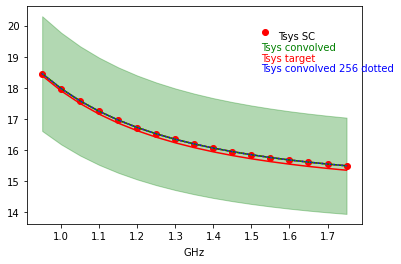

Band 3
  Observing freq 1.65 GHz
    FWHM 47.96679328000001 arcmin
    npixels 182
    target pix data 38.691765
    data max 45.58612
    data min 35.03851
    data med 39.285892
    convolved 408MHz 39.35215009591004
    convolved 1.65 GHz 0.8437291774519182
    time 0.1064760684967041
    Tsys convolved [15.60733402] K
    Tsys target pixel [15.59334228] K
    256 npixels 56
    256 target pix data 38.242535
    256 data max 45.647346
    256 data min 35.14421
    256 data med 39.22572
    256 convolved 408MHz 39.35935227070449
    256 convolved 1.65 GHz 0.8438835955713951
    256 time 0.025225162506103516
    256 Tsys convolved [15.60733402] K
    256 Tsys target pixel [15.59334228] K

  Observing freq 2.950000000000001 GHz
    FWHM 26.828884376949144 arcmin
    npixels 60
    target pix data 38.691765
    data max 42.974667
    data min 36.681683
    data med 39.118584
    convolved 408MHz 39.21726539295241
    convolved 2.950000000000001 GHz 0.17013051307180674
    time 0.0395641

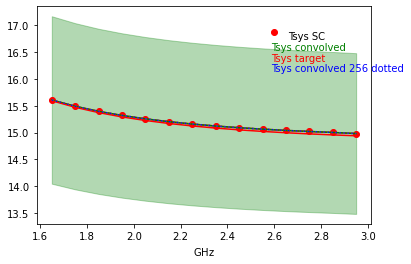

Band 4
  Observing freq 2.8 GHz
    FWHM 28.266146040000002 arcmin
    npixels 74
    target pix data 38.691765
    data max 43.442776
    data min 36.30397
    data med 39.118584
    convolved 408MHz 39.23156710237443
    convolved 2.8 GHz 0.19645655252099034
    time 0.04799818992614746
    Tsys convolved [15.01017627] K
    Tsys target pixel [15.00750509] K
    256 npixels 24
    256 target pix data 38.242535
    256 data max 42.882713
    256 data min 36.064888
    256 data med 39.146194
    256 convolved 408MHz 39.238784112832874
    256 convolved 2.8 GHz 0.19649269252504561
    256 time 0.019572973251342773
    256 Tsys convolved [15.01017627] K
    256 Tsys target pixel [15.00750509] K

  Observing freq 5.000000000000002 GHz
    FWHM 15.829041782399996 arcmin
    npixels 28
    target pix data 38.691765
    data max 41.502056
    data min 37.289192
    data med 39.137398
    convolved 408MHz 39.17906457341794
    convolved 5.000000000000002 GHz 0.03982923814432651
    time 0.011

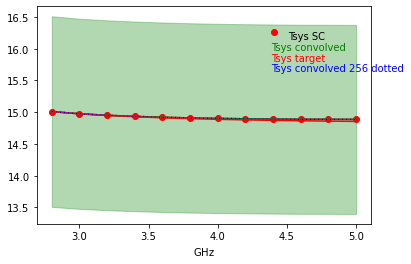


Galactic b=+15
--------------

Band 1
  Observing freq 0.35 GHz
    FWHM 226.12916832000002 arcmin
    npixels 3540
    target pix data 58.753227
    data max 81.22214
    data min 44.600624
    data med 60.128735
    convolved 408MHz 59.612691852446304
    convolved 0.35 GHz 90.87973660778944
    time 2.187206983566284
    Tsys convolved [116.90560644] K
    Tsys target pixel [115.60066498] K
    256 npixels 919
    256 target pix data 58.922066
    256 data max 81.206894
    256 data min 44.473076
    256 data med 60.00849
    256 convolved 408MHz 59.600049785213045
    256 convolved 0.35 GHz 90.86046373644888
    256 time 0.5263569355010986
    256 Tsys convolved [116.90560644] K
    256 Tsys target pixel [115.60066498] K

  Observing freq 0.9999999999999999 GHz
    FWHM 79.14520891200003 arcmin
    npixels 464
    target pix data 58.753227
    data max 67.603584
    data min 50.3071
    data med 60.224915
    convolved 408MHz 58.786437408186295
    convolved 0.9999999999999999 GHz

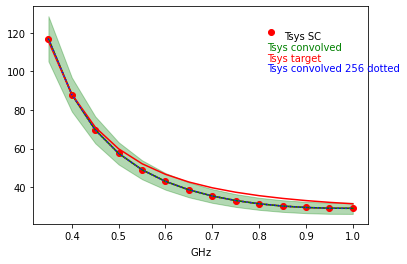

Band 2
  Observing freq 0.95 GHz
    FWHM 83.3107462231579 arcmin
    npixels 511
    target pix data 58.753227
    data max 68.20377
    data min 49.99515
    data med 60.223114
    convolved 408MHz 58.77867665223893
    convolved 0.95 GHz 5.751688242703258
    time 0.251431941986084
    Tsys convolved [20.38205378] K
    Tsys target pixel [20.37957861] K
    256 npixels 142
    256 target pix data 58.922066
    256 data max 68.372734
    256 data min 50.19017
    256 data med 60.214935
    256 convolved 408MHz 58.79337817160964
    256 convolved 0.95 GHz 5.753126835079446
    256 time 0.12090897560119629
    256 Tsys convolved [20.38205378] K
    256 Tsys target pixel [20.37957861] K

  Observing freq 1.7500000000000007 GHz
    FWHM 45.22583366399999 arcmin
    npixels 159
    target pix data 58.753227
    data max 62.981117
    data min 52.52592
    data med 59.5285
    convolved 408MHz 58.78204424659493
    convolved 1.7500000000000007 GHz 1.0720264479098496
    time 0.092653751373

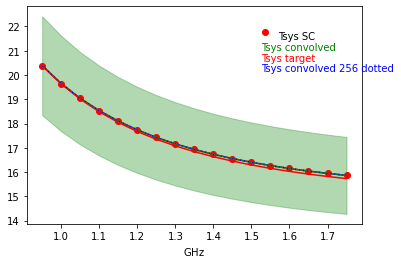

Band 3
  Observing freq 1.65 GHz
    FWHM 47.96679328000001 arcmin
    npixels 187
    target pix data 58.753227
    data max 63.63483
    data min 51.857788
    data med 59.5285
    convolved 408MHz 58.76370679791101
    convolved 1.65 GHz 1.2599223645922255
    time 0.10033392906188965
    Tsys convolved [16.04147807] K
    Tsys target pixel [16.04125475] K
    256 npixels 54
    256 target pix data 58.922066
    256 data max 63.553177
    256 data min 51.642727
    256 data med 59.637012
    256 convolved 408MHz 58.74409319815659
    256 convolved 1.65 GHz 1.2595018395040833
    256 time 0.05480813980102539
    256 Tsys convolved [16.04147807] K
    256 Tsys target pixel [16.04125475] K

  Observing freq 2.950000000000001 GHz
    FWHM 26.828884376949144 arcmin
    npixels 67
    target pix data 58.753227
    data max 61.095806
    data min 54.52899
    data med 59.32198
    convolved 408MHz 58.84298952790906
    convolved 2.950000000000001 GHz 0.25526991488960765
    time 0.04321169

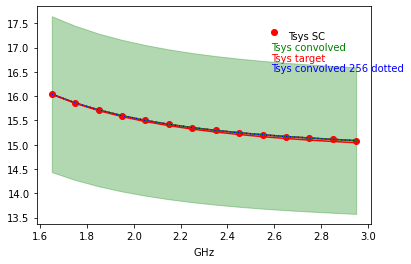

Band 4
  Observing freq 2.8 GHz
    FWHM 28.266146040000002 arcmin
    npixels 71
    target pix data 58.753227
    data max 61.434982
    data min 54.52899
    data med 59.43235
    convolved 408MHz 58.842840917844114
    convolved 2.8 GHz 0.29466224576486694
    time 0.04401373863220215
    Tsys convolved [15.12455627] K
    Tsys target pixel [15.12411025] K
    256 npixels 22
    256 target pix data 58.922066
    256 data max 61.427032
    256 data min 55.149162
    256 data med 59.56977
    256 convolved 408MHz 58.84120393301307
    256 convolved 2.8 GHz 0.2946540483763813
    256 time 0.012718915939331055
    256 Tsys convolved [15.12455627] K
    256 Tsys target pixel [15.12411025] K

  Observing freq 5.000000000000002 GHz
    FWHM 15.829041782399996 arcmin
    npixels 25
    target pix data 58.753227
    data max 60.54842
    data min 56.793602
    data med 59.176636
    convolved 408MHz 58.84008358318602
    convolved 5.000000000000002 GHz 0.05981653025623382
    time 0.0128729

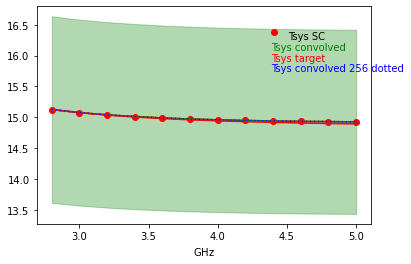


Test
----

Band 1
  Observing freq 0.35 GHz
    FWHM 226.12916832000002 arcmin
    npixels 3541
    target pix data 33.131
    data max 33.131
    data min 24.722786
    data med 27.697306
    convolved 408MHz 28.661257834060127
    convolved 0.35 GHz 43.69417789846772
    time 2.401019334793091
    Tsys convolved [69.50154892] K
    Tsys target pixel [76.22787805] K
    256 npixels 919
    256 target pix data 32.988995
    256 data max 32.988995
    256 data min 24.594166
    256 data med 27.703156
    256 convolved 408MHz 28.651110661180518
    256 convolved 0.35 GHz 43.678708501432354
    256 time 0.5344738960266113
    256 Tsys convolved [69.50154892] K
    256 Tsys target pixel [76.22787805] K

  Observing freq 0.9999999999999999 GHz
    FWHM 79.14520891200003 arcmin
    npixels 464
    target pix data 33.131
    data max 33.131
    data min 27.10262
    data med 30.24656
    convolved 408MHz 31.135306944046704
    convolved 0.9999999999999999 GHz 2.6458705965186815
    time 0.30

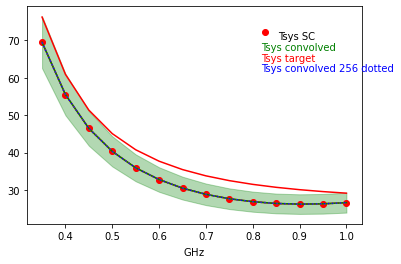

Band 2
  Observing freq 0.95 GHz
    FWHM 83.3107462231579 arcmin
    npixels 512
    target pix data 33.131
    data max 33.131
    data min 26.785604
    data med 30.133863
    convolved 408MHz 31.02087200153972
    convolved 0.95 GHz 3.035495096721651
    time 0.31717705726623535
    Tsys convolved [17.60633618] K
    Tsys target pixel [17.80884088] K
    256 npixels 142
    256 target pix data 32.988995
    256 data max 32.988995
    256 data min 26.566381
    256 data med 30.018284
    256 convolved 408MHz 30.974819195947873
    256 convolved 0.95 GHz 3.030988677122699
    256 time 0.10791397094726562
    256 Tsys convolved [17.60633618] K
    256 Tsys target pixel [17.80884088] K

  Observing freq 1.7500000000000007 GHz
    FWHM 45.22583366399999 arcmin
    npixels 165
    target pix data 33.131
    data max 33.131
    data min 29.370604
    data med 31.535648
    convolved 408MHz 32.14074554446738
    convolved 1.7500000000000007 GHz 0.5861607863562113
    time 0.140420913696289

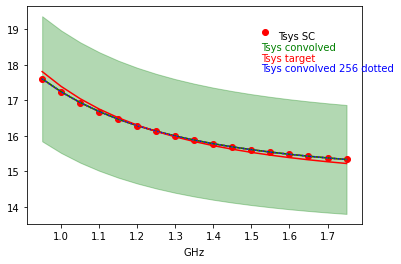

Band 3
  Observing freq 1.65 GHz
    FWHM 47.96679328000001 arcmin
    npixels 182
    target pix data 33.131
    data max 33.131
    data min 29.17687
    data med 31.469383
    convolved 408MHz 32.05652678078558
    convolved 1.65 GHz 0.6873074763843378
    time 0.1543722152709961
    Tsys convolved [15.42727711] K
    Tsys target pixel [15.44987044] K
    256 npixels 52
    256 target pix data 32.988995
    256 data max 32.988995
    256 data min 29.102425
    256 data med 31.292957
    256 convolved 408MHz 32.009240570201115
    256 convolved 1.65 GHz 0.6862936371032816
    256 time 0.03176593780517578
    256 Tsys convolved [15.42727711] K
    256 Tsys target pixel [15.44987044] K

  Observing freq 2.950000000000001 GHz
    FWHM 26.828884376949144 arcmin
    npixels 67
    target pix data 33.131
    data max 33.131
    data min 31.036524
    data med 32.39106
    convolved 408MHz 32.67387249848968
    convolved 2.950000000000001 GHz 0.14174427096107012
    time 0.04298210144042969

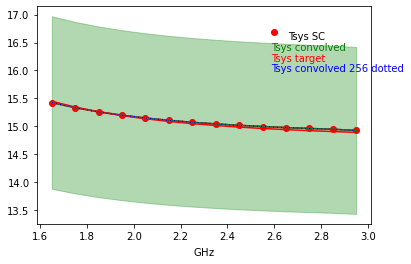

Band 4
  Observing freq 2.8 GHz
    FWHM 28.266146040000002 arcmin
    npixels 70
    target pix data 33.131
    data max 33.131
    data min 30.887146
    data med 32.328506
    convolved 408MHz 32.63783151033048
    convolved 2.8 GHz 0.1634376685373958
    time 0.07016396522521973
    Tsys convolved [14.9559713] K
    Tsys target pixel [14.9583933] K
    256 npixels 22
    256 target pix data 32.988995
    256 data max 32.988995
    256 data min 30.634277
    256 data med 32.18593
    256 convolved 408MHz 32.58259077804942
    256 convolved 2.8 GHz 0.16316104426199146
    256 time 0.010258913040161133
    256 Tsys convolved [14.9559713] K
    256 Tsys target pixel [14.9583933] K

  Observing freq 5.000000000000002 GHz
    FWHM 15.829041782399996 arcmin
    npixels 25
    target pix data 33.131
    data max 33.131
    data min 32.273968
    data med 32.793045
    convolved 408MHz 32.942215309536
    convolved 5.000000000000002 GHz 0.033488888845380746
    time 0.019936084747314453
   

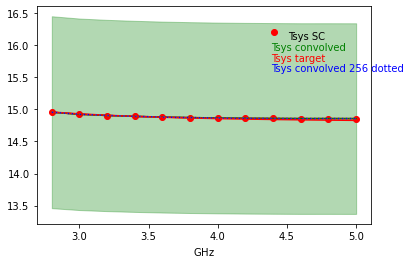

In [13]:
# This cell calculates the beam size for a range of freqs/bands, gets the number
# of map pixels covered by the beam, and the pixel values for GC, anti-centre and 
# l=15.

import time
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord, Galactic
from astropy_healpix import HEALPix
from ska_ost_senscalc.utilities import DishType, TelParams, Celestial

print('The raw resolution of the 408MHz map is 0.85deg or 51 arcsec')

# data from standard NSIDE=512 file
Celestial.HASLAM_408 = '../src/ska_ost_senscalc/static/resources/haslam408_ds_Remazeilles2014_nonIDL.fits'
hdul = fits.open(Celestial.HASLAM_408)
hp = HEALPix(nside=hdul[1].header['NSIDE'], order=hdul[1].header['ORDERING'], frame=Galactic())
hp_data = np.array(hdul[1].data.field(0))
hdul.close()
print('The pixsize of the NSIDE=512 healpix map is', hp.pixel_resolution)

# data from degraded NSIDE=256 file
Celestial.HASLAM_408 = '../src/ska_ost_senscalc/static/resources/haslam408_ds_Remazeilles2014_nonIDL_nside256.fits'
hdul = fits.open(Celestial.HASLAM_408)
hp_256 = HEALPix(nside=hdul[1].header['NSIDE'], order=hdul[1].header['ORDERING'], frame=Galactic())
hp_data_256 = np.array(hdul[1].data.field(0))
hdul.close()

print('The pixsize of the NSIDE=256 healpix map is', hp_256.pixel_resolution)

def convolve(pixvals, offset, fwhm):
    start_time = time.time()
    sum = 0.0
    sumwt = 0.0
    c = fwhm.to(u.arcmin) / 2.355
    for i,v in enumerate(pixvals):
        wt = np.exp(-offset[i].to(u.arcmin)**2 / (2 * c**2))
        sum += (wt * v)
        sumwt += wt
    return sum / sumwt, time.time() - start_time

def go_freq(band, obs_freq, target, fwhm, hp_data):
    print(band)
    alpha = 2.75

    tsys = []
    tsys_convolved = []
    tsys_target = []
    tsys_256 = []
    tsys_convolved_256 = []
    tsys_target_256 = []
    
    for i,v in enumerate(obs_freq):
        
        # Tsys with full full resolution (NSIDE=512) map

        pixels = hp.cone_search_skycoord(target, radius=fwhm[i])
        target_pixel = hp.skycoord_to_healpix(target)
        pixvals = hp_data[pixels]
        target_pixval = hp_data[target_pixel]
        skypixels = hp.healpix_to_skycoord(pixels)
        offset = target.separation(skypixels)
        convolved, time_taken = convolve(pixvals, offset, fwhm[i])
        
        # switch between map files by setting class attribute
        
        Celestial.HASLAM_408 = '../src/ska_ost_senscalc/static/resources/haslam408_ds_Remazeilles2014_nonIDL.fits'
        sc = MidCalculator(band, obs_freq[i], 0.1 * u.GHz, "Good", "full", target)
        tsys.append(sc.Tsys_ska.to_value(u.K))
        sc_convolved = MidCalculator(band, obs_freq[i], 0.1 * u.GHz, "Good", "full", target,
                                     Tgal=u.K * convolved * (0.408 / obs_freq[i].to_value("GHz")) ** alpha)
        tsys_convolved.append(sc_convolved.Tsys_ska[0].to_value(u.K))
        sc_target = MidCalculator(band, obs_freq[0], 0.1 * u.GHz, "Good", "full", target,
                                  Tgal=u.K * target_pixval * (0.408 / obs_freq[i].to_value("GHz")) ** alpha)
        tsys_target.append(sc_target.Tsys_ska[0].to_value(u.K))
        
        if i==0 or i==len(obs_freq)-1:
            print('  Observing freq', v)
            print('    FWHM', fwhm[i].to(u.arcmin))
            print('    npixels', len(pixels))
            print('    target pix data', target_pixval)
            print('    data max', np.max(pixvals))
            print('    data min', np.min(pixvals))
            print('    data med', np.median(pixvals))
            print('    convolved 408MHz', convolved)
            print('    convolved', v, convolved * (0.408 / obs_freq[i].to_value("GHz")) ** alpha)
            print('    time', time_taken)
            print('    Tsys convolved', sc_convolved.Tsys_ska.to(u.K))
            print('    Tsys target pixel', sc_target.Tsys_ska.to(u.K))
        
        # Tsys with NSIDE=256 map
        
        pixels = hp_256.cone_search_skycoord(target, radius=fwhm[i])
        target_pixel = hp_256.skycoord_to_healpix(target)
        pixvals = hp_data_256[pixels]
        target_pixval = hp_data_256[target_pixel]
        skypixels = hp_256.healpix_to_skycoord(pixels)
        offset = target.separation(skypixels)
        convolved, time_taken = convolve(pixvals, offset, fwhm[i])
        
        Celestial.HASLAM_408 = '../src/ska_ost_senscalc/static/resources/haslam408_ds_Remazeilles2014_nonIDL_nside256.fits'
        sc_256 = MidCalculator(band, obs_freq[i], 0.1 * u.GHz, "Good", "full", target)
        tsys_256.append(sc.Tsys_ska.to_value(u.K))
        sc_convolved_256 = MidCalculator(band, obs_freq[i], 0.1 * u.GHz, "Good", "full", target,
                                         Tgal=u.K * convolved * (0.408 / obs_freq[i].to_value("GHz")) ** alpha)
        tsys_convolved_256.append(sc_convolved_256.Tsys_ska[0].to_value(u.K))
        sc_target_256 = MidCalculator(band, obs_freq[0], 0.1 * u.GHz, "Good", "full", target,
                                      Tgal=u.K * target_pixval * (0.408 / obs_freq[i].to_value("GHz")) ** alpha)
        tsys_target_256.append(sc_target_256.Tsys_ska[0].to_value(u.K))
        
        if i==0 or i==len(obs_freq)-1:
            print('    256 npixels', len(pixels))
            print('    256 target pix data', target_pixval)
            print('    256 data max', np.max(pixvals))
            print('    256 data min', np.min(pixvals))
            print('    256 data med', np.median(pixvals))
            print('    256 convolved 408MHz', convolved)
            print('    256 convolved', v, convolved * (0.408 / obs_freq[i].to_value("GHz")) ** alpha)
            print('    256 time', time_taken)
            print('    256 Tsys convolved', sc_convolved.Tsys_ska.to(u.K))
            print('    256 Tsys target pixel', sc_target.Tsys_ska.to(u.K))
            print('')
    
    tsys_convolved = np.array(tsys_convolved)
    plt.figure()
    plt.plot(obs_freq, tsys, color='red', marker='o')
    plt.plot(0.71, 0.88, color='red', marker='o', transform=plt.gca().transAxes)
    plt.text(0.75, 0.85, 'Tsys SC', color='black', transform=plt.gca().transAxes)
    plt.plot(obs_freq, tsys_convolved, color='green')
    plt.text(0.7, 0.8, 'Tsys convolved', color='green', transform=plt.gca().transAxes)
    plt.fill_between(obs_freq, 0.9*tsys_convolved, 1.1*tsys_convolved, alpha=0.3, color='green')
    plt.plot(obs_freq, tsys_target, color='red')
    plt.text(0.7, 0.75, 'Tsys target', color='red', transform=plt.gca().transAxes)
    plt.plot(obs_freq, tsys_256, color='orange', linestyle='dotted')
    plt.plot(obs_freq, tsys_convolved_256, color='blue', linestyle='dotted')
    plt.text(0.7, 0.7, 'Tsys convolved 256 dotted', color='blue', transform=plt.gca().transAxes)

    plt.show()

def go_fwhm(target):
    obs_freq = np.arange(0.35, 1.050, 0.05) * u.GHz
    fwhm = TelParams.dish_fwhm(obs_freq, DishType.SKA1)
    go_freq('Band 1', obs_freq, target, fwhm, hp_data)
    
    obs_freq = np.arange(0.95, 1.76, 0.05) * u.GHz
    fwhm = TelParams.dish_fwhm(obs_freq, DishType.SKA1)
    go_freq('Band 2', obs_freq, target, fwhm, hp_data)
    
    obs_freq = np.arange(1.65, 3.05, 0.1) * u.GHz
    fwhm = TelParams.dish_fwhm(obs_freq, DishType.SKA1)
    go_freq('Band 3', obs_freq, target, fwhm, hp_data)
     
    obs_freq = np.arange(2.8, 5.18, 0.2) * u.GHz
    fwhm = TelParams.dish_fwhm(obs_freq, DishType.SKA1)
    go_freq('Band 4', obs_freq, target, fwhm, hp_data)
    
print("""
Galactic Centre
---------------
""")
go_fwhm(SkyCoord(359.94423568 * u.deg, -00.04616002 * u.deg, frame="galactic"))

print("""
Galactic anti-Centre
--------------------
""")
go_fwhm(SkyCoord(180.0 * u.deg, 0.0 * u.deg, frame="galactic"))

print("""
Galactic b=+15
--------------
""")
go_fwhm(SkyCoord(0.0 * u.deg, +15.0 * u.deg, frame="galactic"))

print("""
Test
----
""")
go_fwhm(SkyCoord(10.625, 41.2, frame="icrs", unit="deg"))

How to Calculate Tgal
---------------------

The results from the cell above are the important ones in this notebook.

They show that there is a lot of structure on scales smaller than the primary beam size in bands 1 and 2. The resolution of the 408MHz map is larger than the primary beams of bands 3 and 4 and this limits how accurately we can estimate Tgal for them.

The spectral index of the Galactic emission means that Tgal increases rapidly for low frequencies, diminishes for high frequencies (relative to 408MHz). This reduces the impact of any error due to low map resolution in Bands 3 and 4. For Band 1 on the other hand, we need to be as accurate as possible as Tgal is the dominant factor in Tsys.

The cell above shows plots Tsys for each Band 1-4 for targets towards the G Centre, G anti-centre, and 15 degrees above the G centre.

The green line in each plot shows the 'correct' answer, with Tgal the convolution of the high resolution (NSIDE=512) map with a Gaussian beam of appropriate FWHM. 

This green line is usually obscured by a blue-dotted line which shows the result of the same calculation using a lower resolution (NSIDE=256) map, which is 4 times faster.

The red line shows the result if Tgal is assumed to be the map pixel at the target position.

The red circles show Tsys calculated by the Sensitivity Calculator - this uses the NSIDE=256 map so should lie on top of the blue dotted line.

The green area shows a 10% error on either side of the 'correct' Tsys. It is evident that the NSIDE=256 calculation is pretty good, but using the target pixel potentially has a large error in Bands 1 and 2 near the Galactic Plane and Centre.

The Spectral Index
------------------

$T_{gal}$ is estimated by the SC in 2 steps:

1. Use the Haslam map to estimate $T_{gal}$ at 408MHz.
2. Use the spectral index $\alpha$ to calculate $T_{gal}$ at the required observing frequency.

The spectral index defaults to 2.76 in the SC but this value can be overridden by the user.

In their paper 'All-sky Galactic radiation at 45 MHz and spectral index between 45 and 408 MHz' (https://arxiv.org/abs/1011.4298), Guzman et al. produce an all-sky map of the spectral index. 

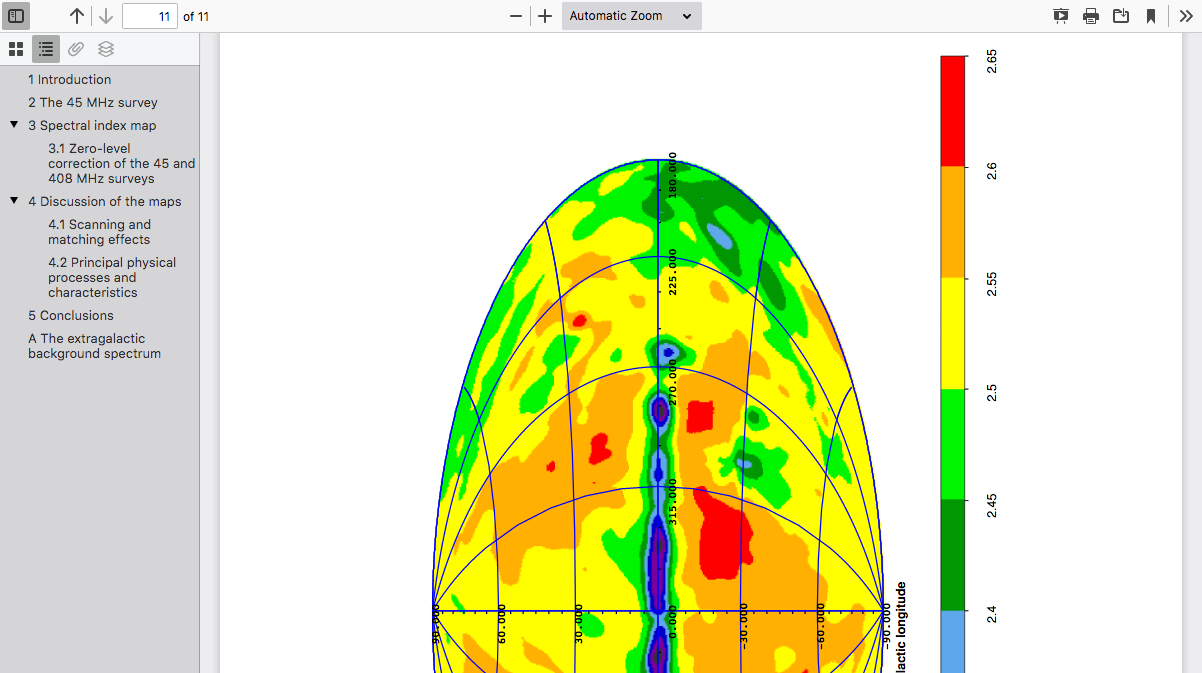

Guzman et al. conclude:

> The spectral index map has allowed us to derive some con-clusions about overall Galactic features: the sky has spectral indices that range between 2.1 and 2.7. Over most ofthe sky, the index is between 2.5 and 2.6, which is reduced by thermal absorption to values between 2.1 to 2.5 across the Galactic plane strip (|b|<10◦). This absorption is probably due to HII regions rather than a more extended global structure such as the WIM. There is a large zone around l∼70◦,b∼+25◦adjacent to the Northern Polar Spur where the average spectral index is close to the maximum spectral index.of 2.7

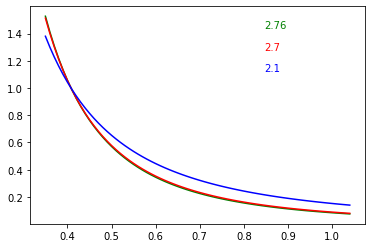

In [14]:
# What is the effect of the spectral index?

import numpy as np
import matplotlib.pyplot as plt

def go(obs_ffreq, alpha):
     return(0.408 / obs_freq) ** alpha
    
obs_freq = np.arange(0.35, 1.05, 0.01)
plt.figure()

v = go(obs_freq, 2.76)
plt.plot(obs_freq, v, color='green')
plt.text(0.7, 0.9, '2.76', color='green', transform=plt.gca().transAxes)

v = go(obs_freq, 2.7)
plt.plot(obs_freq, v, color='red')
plt.text(0.7, 0.8, '2.7', color='red', transform=plt.gca().transAxes)

v = go(obs_freq, 2.1)
plt.plot(obs_freq, v, color='blue')
plt.text(0.7, 0.7, '2.1', color='blue', transform=plt.gca().transAxes)

plt.show()

Effect of Spectral Index
------------------------

The effect of possible error in spectral index is within 10% for frequencies below 408MHz. The effect is worse for frequencies above 408MHz but the Guzman et al. paper does not attempt to measure the index here - more investigation needed.

LOW
---

The effect of Tgal will be strong for LOW because of the low observing frequencies. Acoording to ref? the effective beam of a LOW station can be approximated as a dish 38m in diameter. TBD. 
